In [4]:
import joblib
import numpy as np
from numpy import logical_and as land
from numpy import logical_not as lnot
from skimage.feature import canny
from skimage.transform import rescale, ProjectiveTransform, warp
from skimage.morphology import dilation, disk
import cv2

# make a prediction for a new image.
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
from skimage.segmentation import clear_border

kernel = np.ones((3, 3), 'uint8')
SCALE = 0.33


def resize(img, scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized = cv2.resize(img, dim, interpolation=cv2.INTER_AREA)
    return resized


def area_of_image(img):
    ar = img.shape[0] * img.shape[1]
    return ar


# load an image and predict the class
def run_example(crop_img):
    # load the image
    img_nn = crop_img

    # reshape into a single sample with 1 channel
    img_nn = cv2.resize(img_nn, (28, 28), interpolation=cv2.INTER_AREA)
    img_nn = img_nn.reshape(1, 28, 28, 1)

    # prepare pixel data
    img_nn = img_nn.astype('float32')
    img_nn = img_nn / 255.0
    # load model
    
#     model = load_model('/autograder/submission/final_sauten.h5')
    model = load_model('final_sauten.h5')

    # predict the class
    predict_value = model.predict(img_nn)
    digit = argmax(predict_value)
    return digit


# Кормление картинки для примера


def predict_image(image: np.ndarray) -> (np.ndarray, list):
    global approx, dst, otsu_img, img, dst_list,sudoku_digits_part
    k = 0
    k += 1
    img = image
    img_doublicated = image.copy()

    imgGray = cv2.cvtColor(img_doublicated, cv2.COLOR_BGR2GRAY)

    imgBlur = cv2.GaussianBlur(imgGray, (1, 1), 1)

    #     otsu_threshold, otsu_img = cv2.threshold(
    #         imgBlur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU,
    #     )

    otsu_threshold, otsu_img = cv2.threshold(
        imgBlur, 110, 255, cv2.THRESH_BINARY_INV
    )

    imgDialation = cv2.dilate(otsu_img, kernel, iterations=1)

    contours, hierarchy = cv2.findContours(imgDialation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    mask = np.zeros(otsu_img.shape[:2], np.uint8)
    # print(mask)
    
    dst_list = []
    for cnt in contours:

        area = cv2.contourArea(cnt)

        parameter = area / area_of_image(image)

        if parameter > 0.1 and parameter < 0.8:
            #             print(parameter)

            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
            rect = cv2.minAreaRect(approx)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            A1A2 = int(np.sqrt((np.square(box[0][0] - box[1][0]) + np.square(box[0][1] - box[1][1]))))
            A2A3 = int(np.sqrt((np.square(box[1][0] - box[2][0]) + np.square(box[1][1] - box[2][1]))))

            aspRatio = A1A2 / A2A3
            #             print('aspRatio = ', aspRatio)

            if aspRatio > 0.6 and aspRatio < 1.4:
                try:
                    cv2.drawContours(mask, [approx], -1, (255, 255, 255), -1, cv2.LINE_AA)
                except:
                    pass

                if approx[0, 0, 0] > approx[2, 0, 0]:
                    pts1 = np.float32([approx[1, 0], approx[0, 0], approx[2, 0], approx[3, 0]])
                else:
                    pts1 = np.float32([approx[0, 0], approx[3, 0], approx[1, 0], approx[2, 0]])

                pts2 = np.float32([[0, 0], [900, 0], [0, 900], [900, 900]])

                M = cv2.getPerspectiveTransform(pts1, pts2)
                dst = cv2.warpPerspective(img, M, (900, 900))
                dst_list.append(dst)
                cv2.imshow("cropped", dst)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
                
    sudoku_digits = []
    sudoku_digits_part = [
        np.int16([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
    ]
    
    for y in range(0, len(dst_list)):
        print(len(dst_list))
        print(y)
#         print(dst_list)
        for i in range(0, dst_list[y].shape[0], 100):
            for j in range(0, dst_list[y].shape[1], 100):
                #         print(f"Li {i}. Ui {i+50}.")
                #         print(f"Lj {j}. Uj {j+50}.")
                #         th_dst, im_th_dst = cv2.threshold(dst, 150, 255, cv2.THRESH_BINARY)

                im_th_dst = cv2.cvtColor(dst_list[y], cv2.COLOR_BGR2GRAY)

                crop_img = im_th_dst[i + 0:i + 100, j + 0:j + 100]
                #             print(crop_img)
                #         crop_img = cv2.bitwise_not(crop_img)

                blur_digits = cv2.GaussianBlur(crop_img, (5, 5), 3)
                #         blur = cv2.bitwise_not(blur)

                ret3, crop_img = cv2.threshold(blur_digits, 100, 255, cv2.THRESH_BINARY_INV)
                #         crop_img = cv2.bitwise_not(crop_img)
                #         crop_img = cv2.erode(crop_img,kernel,iterations = 1)

                #         img = cv2.imread('img.png', cv2.IMREAD_GRAYSCALE)
                crop_img = clear_border(labels=crop_img, buffer_size=1, bgval=0)
#                 cv2.imshow("cropped", crop_img)
#                 cv2.waitKey(0)
#                 cv2.destroyAllWindows()
                n_white_pix = np.sum(crop_img == 255)

    #             print('Number of white pixels:', n_white_pix)
                #         cv2.imwrite('crop_img.jpg', crop_img)

                if n_white_pix >= 200:
                    sudoku_digits_part[0][int(i / 100)][int(j / 100)] = run_example(crop_img)
#         print(sudoku_digits_part[y])
        sudoku_digits.append(sudoku_digits_part[0])
        sudoku_digits_part = [
        np.int16([[-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1, -1, -1, -1, -1]]),
    ]

    mask = np.uint8(mask)
#     mask = np.bool_(mask)

    return mask, sudoku_digits




# ==========================================
#________________$$$$__________________$$$$
#  _______________$__$$_________________$$__$
#  ______________$$___$_________________$___$$
#  ______________$$___$_________________$___$$
#  _____________$$___$$_________________$___$$
#  ____________$$____$__________________$____$$
#  __________$$$____$$__________________$$____$$$
#  _________$$_____$$____________________$$_____$$
#  ________$$______$$____________________$$______$$
#  _______$$_______$_______________________$_______$$
#  ______$$________$$$$$$$___________$$$$$$$________$$
#  __$$$$$_______________$$$_______$$$_______________$$$$
#  _$$$____________$$$$____$$_____$$____$$$$____________$$
#  $$____________$$$__$$$___$_____$___$$$__$$$___________$
#  $____________$$$________$$_____$$________$$$___________$
#  $____________$$$$$$____$$_______$$____$$$$$$___________$
#  $___________$$____$$$$$$$_______$$$$$$$____$$__________$
#  $___________$$$$_______$$_______$$_______$$$$__________$
#  $$_________$$__$$$$$$$$$_________$$$$$$$$$__$$________$
#  _$$$$_____$$$$________$___________$________$$$$______$$
#  __$$$$$____$$$$$$____$$___________$$____$$$$$$____$$$$
#  ______$$__$$____$$$$$$_____________$$$$$$____$$__$$
#  _______$$$_$$$_____$________________$_____$$$_$$$
#  _________$$$$$$$$$$__________________$$$$$$$$$..

img1 = cv2.imread("./train_8.jpg")
# CHANGE THE FILE PATH HERE
# ==========================================
#________________$$$$__________________$$$$
#  _______________$__$$_________________$$__$
#  ______________$$___$_________________$___$$
#  ______________$$___$_________________$___$$
#  _____________$$___$$_________________$___$$
#  ____________$$____$__________________$____$$
#  __________$$$____$$__________________$$____$$$
#  _________$$_____$$____________________$$_____$$
#  ________$$______$$____________________$$______$$
#  _______$$_______$_______________________$_______$$
#  ______$$________$$$$$$$___________$$$$$$$________$$
#  __$$$$$_______________$$$_______$$$_______________$$$$
#  _$$$____________$$$$____$$_____$$____$$$$____________$$
#  $$____________$$$__$$$___$_____$___$$$__$$$___________$
#  $____________$$$________$$_____$$________$$$___________$
#  $____________$$$$$$____$$_______$$____$$$$$$___________$
#  $___________$$____$$$$$$$_______$$$$$$$____$$__________$
#  $___________$$$$_______$$_______$$_______$$$$__________$
#  $$_________$$__$$$$$$$$$_________$$$$$$$$$__$$________$
#  _$$$$_____$$$$________$___________$________$$$$______$$
#  __$$$$$____$$$$$$____$$___________$$____$$$$$$____$$$$
#  ______$$__$$____$$$$$$_____________$$$$$$____$$__$$
#  _______$$$_$$$_____$________________$_____$$$_$$$
#  _________$$$$$$$$$$__________________$$$$$$$$$..
a, b = predict_image(img1)

a = resize(a, 40)
print(b)


arr = b[0]
print(f'NumPy Array:\n{arr}')

list1 = arr.tolist()

print(f'List: {list1}')


rr = (F'''
{b[0][0][0]} {b[0][0][1]} {b[0][0][2]} {b[0][0][3]} {b[0][0][4]} {b[0][0][5]} {b[0][0][6]} {b[0][0][7]} {b[0][0][8]}
{b[0][1][0]} {b[0][1][1]} {b[0][1][2]} {b[0][1][3]} {b[0][1][4]} {b[0][1][5]} {b[0][1][6]} {b[0][1][7]} {b[0][1][8]}
{b[0][2][0]} {b[0][2][1]} {b[0][2][2]} {b[0][2][3]} {b[0][2][4]} {b[0][2][5]} {b[0][2][6]} {b[0][2][7]} {b[0][2][8]}
{b[0][3][0]} {b[0][3][1]} {b[0][3][2]} {b[0][3][3]} {b[0][3][4]} {b[0][3][5]} {b[0][3][6]} {b[0][3][7]} {b[0][3][8]}
{b[0][4][0]} {b[0][4][1]} {b[0][4][2]} {b[0][4][3]} {b[0][4][4]} {b[0][4][5]} {b[0][4][6]} {b[0][4][7]} {b[0][4][8]}
{b[0][5][0]} {b[0][5][1]} {b[0][5][2]} {b[0][5][3]} {b[0][5][4]} {b[0][5][5]} {b[0][5][6]} {b[0][5][7]} {b[0][5][8]}
{b[0][6][0]} {b[0][6][1]} {b[0][6][2]} {b[0][6][3]} {b[0][6][4]} {b[0][6][5]} {b[0][6][6]} {b[0][6][7]} {b[0][6][8]}
{b[0][7][0]} {b[0][7][1]} {b[0][7][2]} {b[0][7][3]} {b[0][7][4]} {b[0][7][5]} {b[0][7][6]} {b[0][7][7]} {b[0][7][8]}
{b[0][8][0]} {b[0][8][1]} {b[0][8][2]} {b[0][8][3]} {b[0][8][4]} {b[0][8][5]} {b[0][8][6]} {b[0][8][7]} {b[0][8][8]}
''')


rr = rr.replace('-1','?') 

from solver import solve, print_field

solution = next(solve(rr))
print_field(solution)

import cv2
    
    
# Window name in which image is displayed
window_name = 'Image'
  
# font
font = cv2.FONT_HERSHEY_SIMPLEX
  
# org
org = (0, 0)
  
# fontScale
fontScale = 2
   
# Blue color in BGR
color = (255, 0, 0)
  
thickness = 2
   
for i in range(0, dst_list[0].shape[0], 100):
            for j in range(0, dst_list[0].shape[1], 100):

                org = (j+30,i+70)
                kjk = str(solution[int(i/100)][int(j/100)])
                image = cv2.putText(dst, kjk, org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
   
cv2.imshow('8_filled_Sautenkov',image)
# cv2.imwrite('8_filled_Sautenkov.jpg',image)
cv2.waitKey(0)
cv2.destroyAllWindows()

1
0
[array([[ 4, -1, -1,  5, -1,  7, -1, -1,  6],
       [-1,  5, -1, -1,  6, -1, -1,  3, -1],
       [-1, -1, -1,  2, -1,  1, -1, -1, -1],
       [ 5, -1,  1,  9,  8,  6,  7, -1,  4],
       [-1,  8, -1,  4, -1,  3, -1,  6, -1],
       [ 6, -1,  4,  7,  1,  2,  8, -1,  3],
       [-1, -1, -1,  1, -1,  5, -1, -1, -1],
       [-1,  4, -1, -1,  7, -1, -1,  1, -1],
       [ 8, -1, -1,  3, -1,  4, -1, -1,  7]], dtype=int16)]
NumPy Array:
[[ 4 -1 -1  5 -1  7 -1 -1  6]
 [-1  5 -1 -1  6 -1 -1  3 -1]
 [-1 -1 -1  2 -1  1 -1 -1 -1]
 [ 5 -1  1  9  8  6  7 -1  4]
 [-1  8 -1  4 -1  3 -1  6 -1]
 [ 6 -1  4  7  1  2  8 -1  3]
 [-1 -1 -1  1 -1  5 -1 -1 -1]
 [-1  4 -1 -1  7 -1 -1  1 -1]
 [ 8 -1 -1  3 -1  4 -1 -1  7]]
List: [[4, -1, -1, 5, -1, 7, -1, -1, 6], [-1, 5, -1, -1, 6, -1, -1, 3, -1], [-1, -1, -1, 2, -1, 1, -1, -1, -1], [5, -1, 1, 9, 8, 6, 7, -1, 4], [-1, 8, -1, 4, -1, 3, -1, 6, -1], [6, -1, 4, 7, 1, 2, 8, -1, 3], [-1, -1, -1, 1, -1, 5, -1, -1, -1], [-1, 4, -1, -1, 7, -1, -1, 1, -1], [8, -1, -1, 

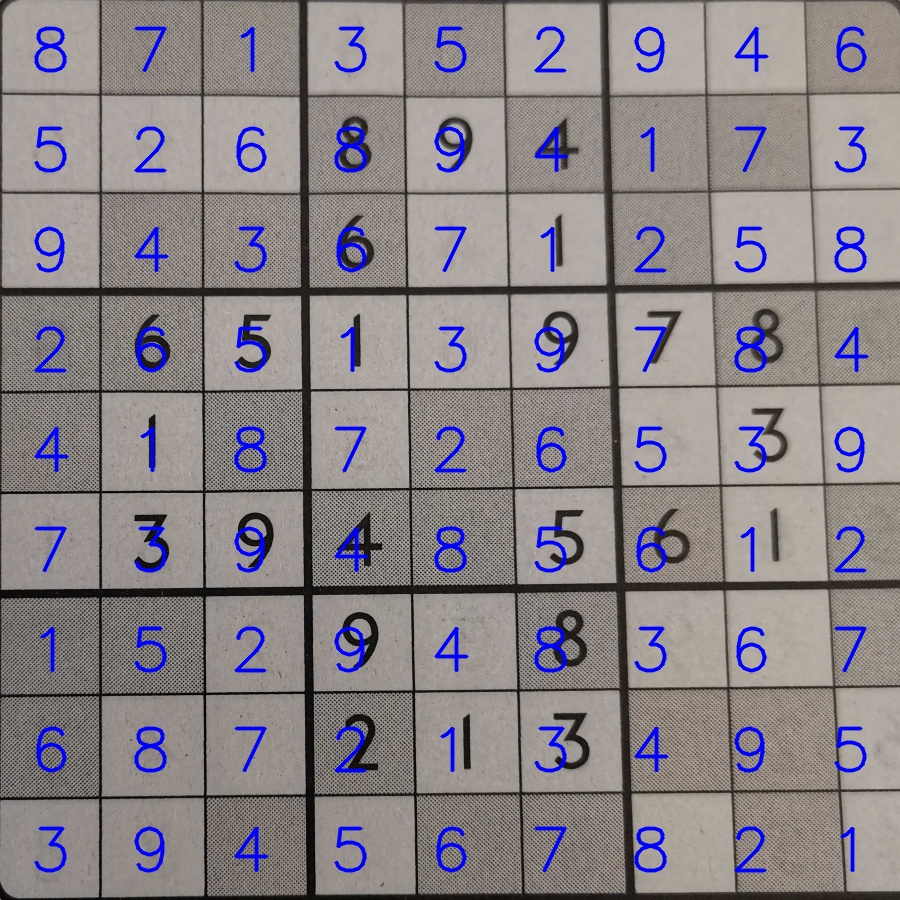
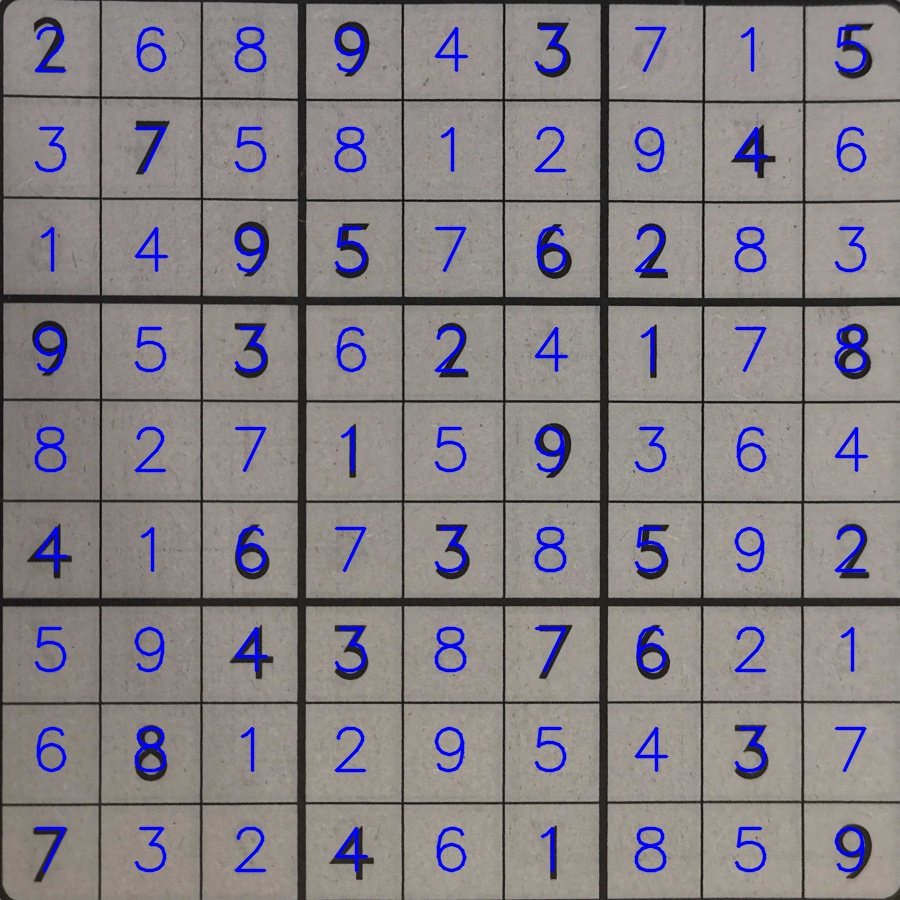
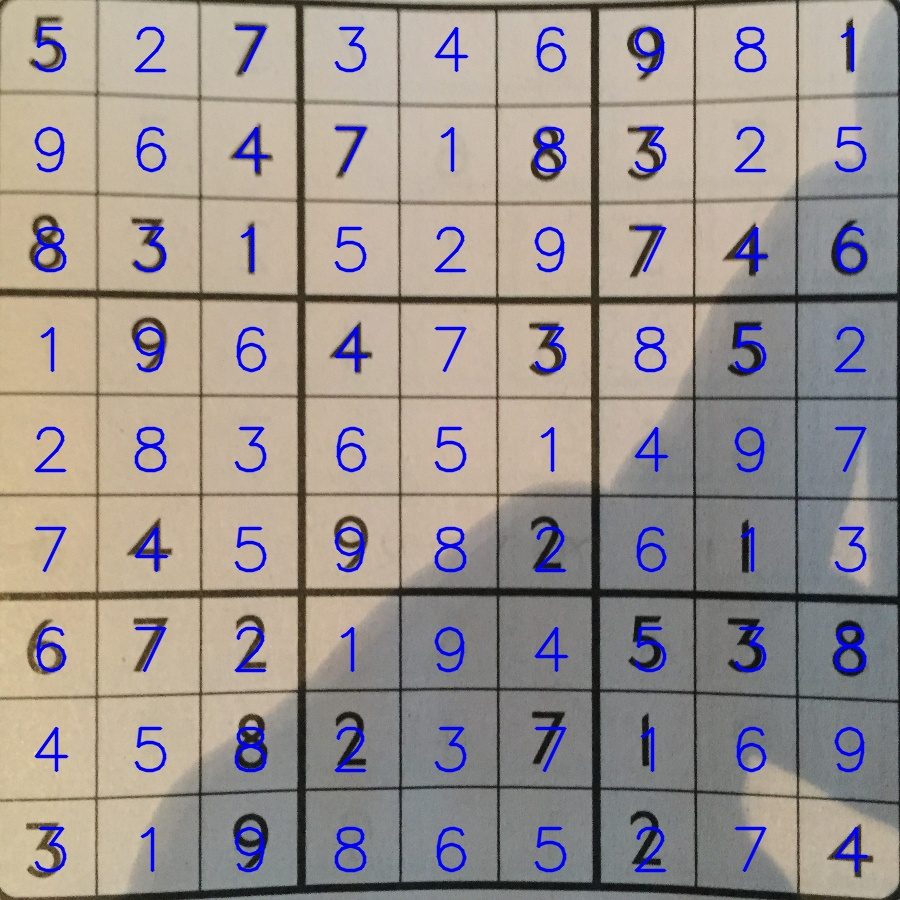
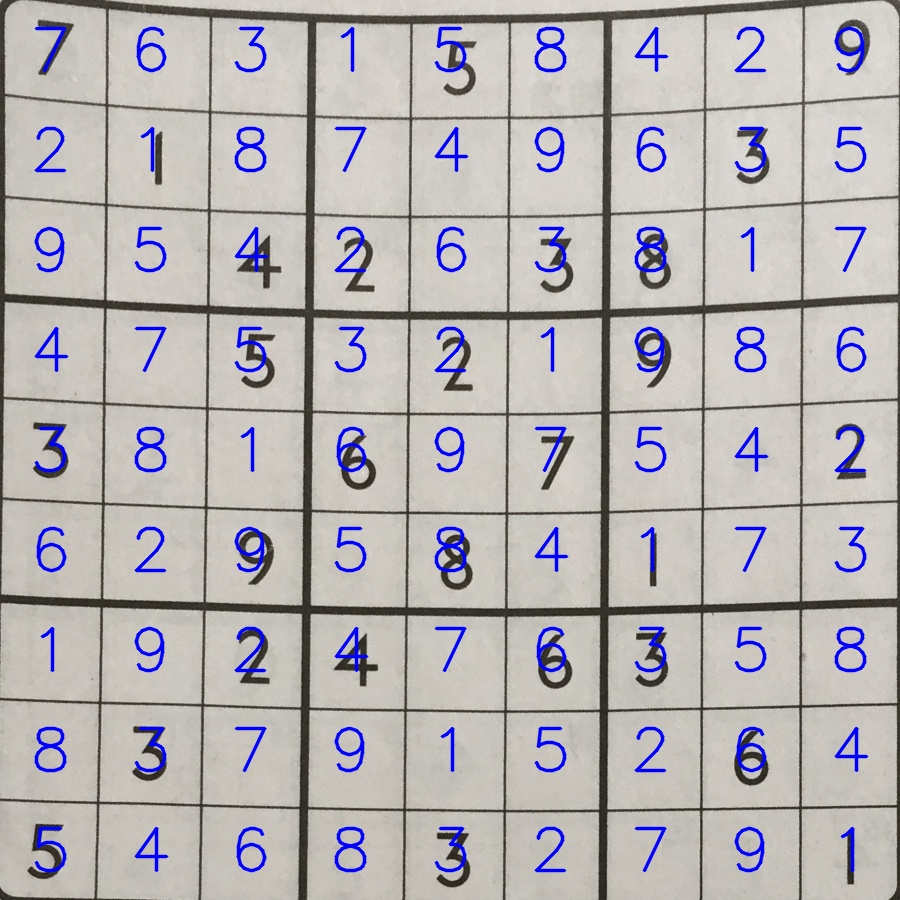
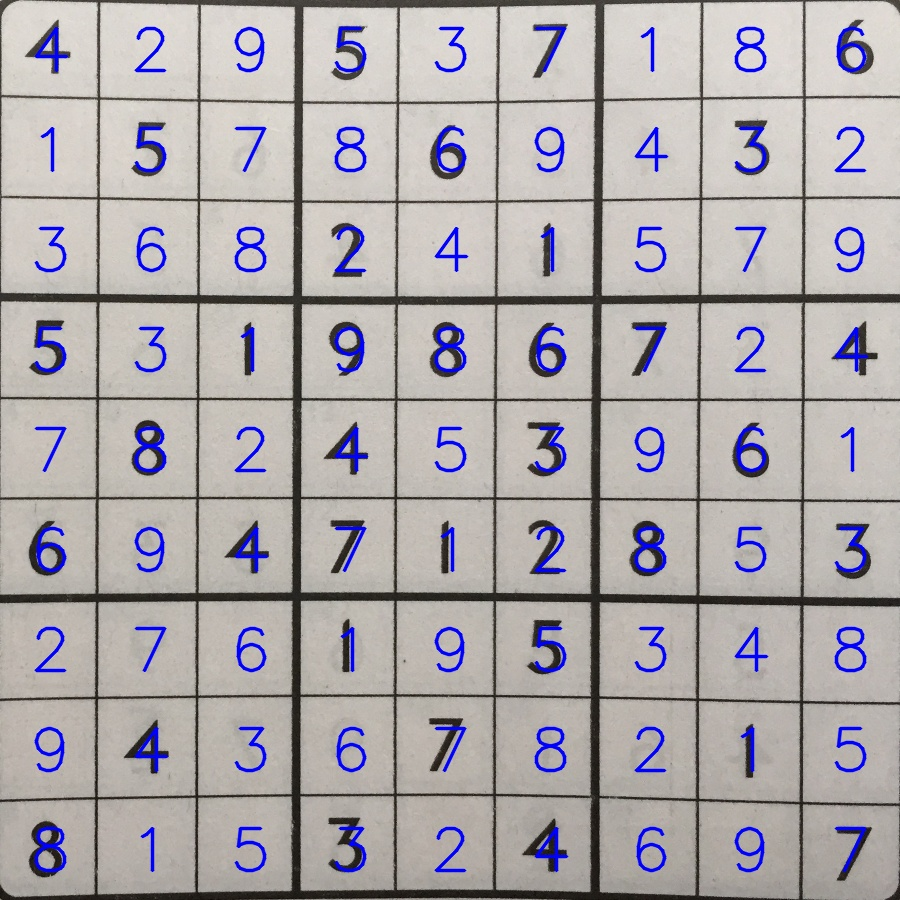